<a href="https://colab.research.google.com/github/dewith/brewerydatacup/blob/main/hackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

# Brewery Data Cup - Colombia

En Bavaria queremos encontrar la mejor estrategia de impulso, mantenimiento o frenado, 
de un listado de marcas establecido, con el objetivo de ofrecer el mejor portafolio a nuestros 
puntos de venta/zonas dependiendo de sus características e historial de compra.

> **¿Qué construir?** <br> El objetivo es encontrar la probabilidad de que un cliente compre cada una de las marcas dadas, con el fin de asignar la estrategia adecuada a cada uno de ellos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 Análisis exploratorio 

### 1.1 Importaciones
Importamos la librerías necesarias

In [ ]:
''' Data manipulation '''
import numpy as np
import pandas as pd

''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline 


''' Machine Learning '''
# Scaling and tranformations
from sklearn.preprocessing import StandardScaler 

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Selection
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

Configuramos el estilo de los gráficos


In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Palette
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FE90AD'
palette = [blue, red, pink, purple, amber, mint]

# Sequential colormap
bluemint = LinearSegmentedColormap.from_list("myBlues", [mint, blue])
redpink = LinearSegmentedColormap.from_list("myReds", [pink, red])
redwhite = LinearSegmentedColormap.from_list("myReds", ['white', red])
bluewhite = LinearSegmentedColormap.from_list("myReds", ['white', blue])

# Diverging colormap
bluered = LinearSegmentedColormap.from_list("myBlueRed", [red, "white", blue])
blupurred = LinearSegmentedColormap.from_list("myBlueRed", [red, purple, blue])
rainbow = LinearSegmentedColormap.from_list("myBlueRed", [pink, red, purple, blue, mint])

params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=palette, rc=params)

### 1.2 Carga de datos

In [ ]:
df_estructura = pd.read_csv('/content/drive/MyDrive/Hackaton/data/Input1_clientes_estructura.csv', sep=';')
df_venta = pd.read_csv('/content/drive/MyDrive/Hackaton/data/Input2_clientes_venta.csv', sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Hackaton/data/Input3_clientes_test.csv', sep=';')

In [ ]:
print('Shape de Estructura:', df_estructura.shape)
print('Shape de Ventas:', df_venta.shape)
print('Shape de Test:', df_test.shape)

Shape de Estructura: (20921, 6)
Shape de Ventas: (1406116, 10)
Shape de Test: (9302, 6)


Revisamos que no haya registros duplicados ni valores faltantes.

In [ ]:
for (name, df) in zip(['Estructura', 'Venta', 'Test'], [df_estructura, df_venta, df_test]):
    print('Valores duplicados en {}:'.format(name), end=' ')
    print(df.duplicated().sum())

Valores duplicados en Estructura: 0
Valores duplicados en Venta: 0
Valores duplicados en Test: 0


In [ ]:
for (name, df) in zip(['Estructura', 'Venta', 'Test'], [df_estructura, df_venta, df_test]):
    print('Valores faltantes en {}:'.format(name),)
    print('='*40)
    print(df.isna().sum(), '\n')

Valores faltantes en Estructura:
Cliente      0
Regional2    0
Gerencia2    0
SubCanal2    0
Categoria    0
Nevera       0
dtype: int64 

Valores faltantes en Venta:
Año                 0
Mes                 0
Cliente             0
SegmentoPrecio2     0
Marca2              0
Cupo2               0
CapacidadEnvase2    0
Volumen             0
disc                0
nr                  0
dtype: int64 

Valores faltantes en Test:
Cliente           0
Marca1         9302
Marca2         9302
Marca3         9302
Marca_Inno1    9302
Marca_Inno2    9302
dtype: int64 



El dataset de test está completamente vacío porque es lo nuestro modelo predecirá. POr lo tanto no hay que realizar ningún tipo de preprocesamiento al respecto.

### 1.3 Exploración de los datasets

#### 1.3.1 Estructura 

El dataset de **estrucutra** representa los datos y atributos de la base de clientes. Cada cliente es un establecimiento donde se comercian los productos: bares, tiendas, etc. 
- Cliente: Id del establecimiento
- Regional2: Región donde se encuentra ubicado
- Gerencia2: Gerencia que le distribuye el producto (Conjunto de 1, 2 o mas ciudades)
- SubCanal2: Tipo de establecimiento (Tienda, Bar, etc)
- Categoria: Variable usada AB-Inbev para calificar la importancia de un establecimiento dada su compra histórica.
- Nevera: Variable dummie que me permite ver si el establecimiento tiene o no una nevera en su punto de venta.

In [ ]:
df_estructura.describe(include='all')

,Cliente,Regional2,Gerencia2,SubCanal2,Categoria,Nevera
count,20921.000000,20921,20921,20921,20921,20921.000000
unique,NaN,1,11,32,6,NaN
top,NaN,Regional 1,Gerencia_10,Subcanal_3,Categoria_2,NaN
freq,NaN,20921,5441,8217,8773,NaN
mean,10461.000000,NaN,NaN,NaN,NaN,0.397830
std,6039.516827,NaN,NaN,NaN,NaN,0.489462
min,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,5231.000000,NaN,NaN,NaN,NaN,0.000000
50%,10461.000000,NaN,NaN,NaN,NaN,0.000000
75%,15691.000000,NaN,NaN,NaN,NaN,1.000000


Con el anterior _describe_ podemos sacar algunas conclusiones:
- Todos los mismos clientes se encuentran en la misma región, por lo que esta variable no tendrá efecto en el modelo.
- Hay un total de 11 gerencias y 32 tipos de establecimiento.
- AB InBev maneja 6 categorías de establecimiento según su importancia comercial. Donde el más común, es la Categoria_2.
- Casi el 40% de los establecimientos tiene una nevera en su punto de venta.

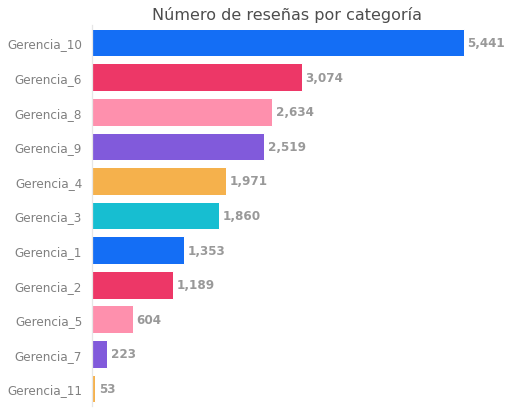

In [ ]:
def put_labels(X, text_format='{:,}', fontsize=12):
    '''
    Función para colocar labels en las barras
    '''
    padding = max(X) * 0.01
    for i, val in enumerate(X):
        ax.text(x=X[i]+padding,
                y=i,
                s=text_format.format(X[i]),
                va='center',
                ha='left',
                color='0.6',
                weight='bold',
                fontsize=fontsize)


#Hallamos el número de reseñas por categoría
category = df_estructura['Gerencia2'].value_counts()

# Creamos el gráfico
plt.figure(figsize=(7, 7))
ax = sns.barplot(x=category.values, 
                 y=category.index,
                 palette=palette, 
                 orient='h',
                 saturation=1,
                )

#change_height(ax, 0.87)
put_labels(category)
ax.set_title('Número de reseñas por categoría')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)

#### 1.3.2 Ventas

In [ ]:
df_venta.head(7)

,Año,Mes,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr
0,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567
1,2019,5,10,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463
2,2019,5,10,SegmentoPrecio_2,Marca_3,Cupo_2,CapacidadEnvase_10,0.043469,0.000000,359.625828
3,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_16,0.026345,-31.065261,134.748399
4,2019,5,10,SegmentoPrecio_1,Marca_4,Cupo_2,CapacidadEnvase_10,0.086938,0.000000,496.901005
5,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_10,0.369485,-114.891895,2853.911219
6,2019,5,10,SegmentoPrecio_1,Marca_5,Cupo_2,CapacidadEnvase_10,0.825907,-221.071444,6153.614786


In [ ]:
df_venta.describe(include='all')

,Año,Mes,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr
count,1.406116e+06,1.406116e+06,1.406116e+06,1406116,1406116,1406116,1406116,1.406116e+06,1.406116e+06,1.406116e+06
unique,NaN,NaN,NaN,3,39,5,17,NaN,NaN,NaN
top,NaN,NaN,NaN,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_10,NaN,NaN,NaN
freq,NaN,NaN,NaN,991679,406526,786172,707919,NaN,NaN,NaN
mean,2.019518e+03,6.865562e+00,8.328064e+03,NaN,NaN,NaN,NaN,2.294363e-01,-1.335855e+02,1.704834e+03
std,4.996729e-01,2.996953e+00,4.906400e+03,NaN,NaN,NaN,NaN,1.395798e+00,1.491833e+03,1.047079e+04
min,2.019000e+03,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,-4.794567e+05,0.000000e+00
25%,2.019000e+03,5.000000e+00,4.148000e+03,NaN,NaN,NaN,NaN,2.173441e-02,-2.877037e+01,1.778085e+02
50%,2.020000e+03,7.000000e+00,8.097000e+03,NaN,NaN,NaN,NaN,5.268947e-02,0.000000e+00,4.233184e+02
75%,2.020000e+03,9.000000e+00,1.231800e+04,NaN,NaN,NaN,NaN,1.496381e-01,0.000000e+00,1.117963e+03


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


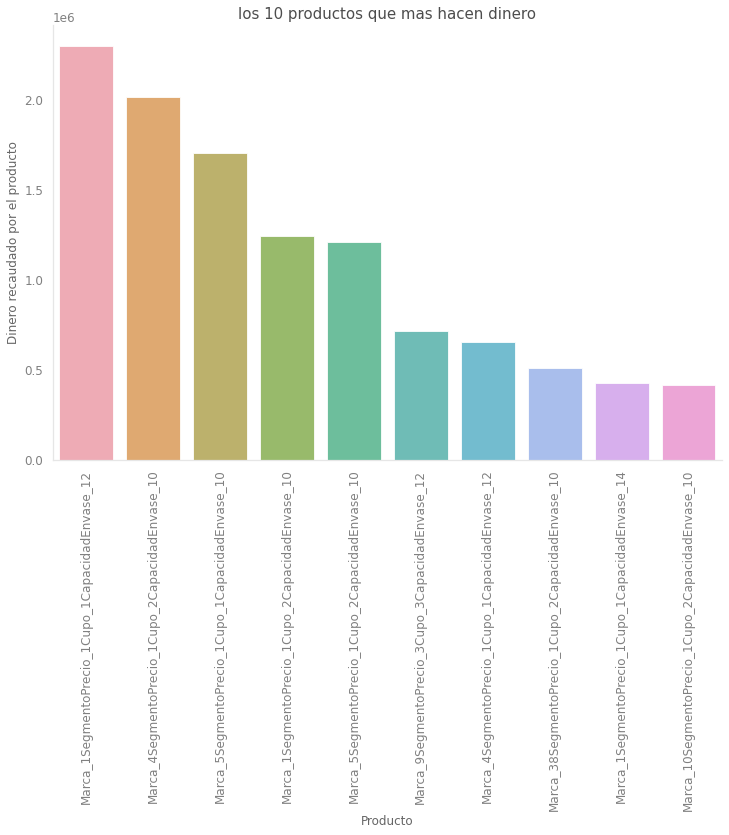

In [ ]:
# Compras del ultimo mes (en ingreso neto)
df_venta['producto'] = df_venta['Marca2'] + df_venta['SegmentoPrecio2'] + df_venta['Cupo2'] + df_venta['CapacidadEnvase2']
trend = df_venta.groupby(['producto'], as_index=False)\
    .max()

trend['nr'] = trend.nr.round()
trend = trend.sort_values('nr',ascending=False)
trend = trend.head(10)

plt.figure(figsize=(12,8))
sns.barplot(trend.producto, trend.nr, alpha=0.8)
plt.ylabel('Dinero recaudado por el producto', fontsize=12)
plt.xlabel('Producto', fontsize=12)
plt.title('los 10 productos que mas hacen dinero', fontsize=15)
plt.xticks( rotation='vertical')

plt.show()

In [ ]:
# Las categorias que venden mas productos
trend = df_venta.groupby(['producto'], as_index=False).count()
trend = trend.sort_values('nr',ascending=False)
trend = trend.head(10)

plt.figure(figsize=(12,8))
sns.barplot(trend.producto, trend.nr, alpha=0.8)
plt.ylabel('numero de df_venta', fontsize=12)
plt.xlabel('Producto', fontsize=12)
plt.title('los 10 productos que mas se venden', fontsize=15)
plt.xticks( rotation='vertical')

plt.show()


In [ ]:
# El mes en que mas se compra
trend = df_venta.groupby(['Mes'], as_index=False).sum()

trend['nr'] = trend.nr.round()
trend = trend.sort_values('nr',ascending=False)


plt.figure(figsize=(12,8))
sns.barplot(trend.Mes, trend.nr, alpha=0.8)
plt.ylabel('Dinero recaudado por el producto', fontsize=12)
plt.xlabel('Mes', fontsize=12)
plt.title('Meses en los que se venden', fontsize=15)
plt.xticks( rotation='vertical')
# ax.set_xticklabels(['Producto '+ i for i in range(30)])
plt.show()


In [ ]:
# porcentaje de volumen consumido por producto
df_venta['producto'] = df_venta['Marca2'] + df_venta['SegmentoPrecio2'] + df_venta['Cupo2'] + df_venta['CapacidadEnvase2']
trend = df_venta.groupby(['producto'], as_index=False)\
    .max()

trend['nr'] = trend.nr.round()
trend = trend.sort_values('nr',ascending=False)

plt.figure(figsize=(10,10))
temp_series = trend['producto'].value_counts()
labels = (np.array(temp_series.index))

plt.pie(trend['nr'], labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("porcentaje sobre el Volumen total consumido por cada producto", fontsize=15)
plt.show()

In [ ]:
df_venta['PorcentajeDescuento'] = (df_venta['disc'].abs() / (df_venta['nr'] + df_venta['disc'].abs())) * 100
df_venta['PorcentajeDescuento'] = df_venta.PorcentajeDescuento.round().fillna(0)
# df_venta.sort_values('PorcentajeDescuento',ascending=False)

In [ ]:
# Hallamos el porcentaje de descuento

plt.figure(figsize=(12,8))

# Plot
plt.title("El porcentaje de descuento por mes", fontsize=15)
sns.boxplot(df_venta['Mes'], df_venta['PorcentajeDescuento'])

plt.show()

In [ ]:
descuento = df_venta.groupby('PorcentajeDescuento').count()['producto']
descuento

In [ ]:
plt.figure(figsize=(10,10))
temp_series = descuento.value_counts()
labels = (np.array(descuento.index))
#sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(descuento, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("descuento por producto", fontsize=15)
plt.show()

In [ ]:
df_ventaProducto = df_venta.groupby(['producto', 'Mes'], as_index=False).count().rename({'nr':'Total'})[['producto', 'Mes', 'nr']]
df_venta.groupby(['producto', 'Mes']).count()
df_ventaProducto.groupby(['Mes'], as_index=False).sum()
trend = df_ventaProducto.groupby(['Mes'], as_index=False).sum()

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(trend.Mes, trend.nr, alpha=0.8)
plt.ylabel('Se mirara los productos vendidos', fontsize=12)
plt.xlabel('Mes', fontsize=12)
plt.title('Productos vendidos', fontsize=15)
plt.xticks( rotation='vertical')
# ax.set_xticklabels(['Producto '+ i for i in range(30)])
plt.show()

## Modelado



### 2.1 Feature engineering

Podemos clasificar los atributos que podríamos usar en las siguientes dos categorías: 

**Atributos directos** <br>
Son los atributos que va vienen en los datos suminsitrados
- Gerencia
- Subcanal
- Categoría 

**Atributos indirectos** <br>
Acá estarán las que crearemos nosotros:
- Descuento promedio por cliente
- Volumen promedio por cliente
- Ingreso promedio por cliente

- Porcentage de compra de cada segmentodemarca (3 columnas)
- Ratio de volumen precio por cada marca

- Compras del ultimo mes (en volumen)
- Compras del ultimo mes (en ingreso neto)

#### 2.1.1 Features indirectas

In [ ]:
train = pd.merge(df_estructura, df_venta, on='Cliente', how='right')
train.shape

(1406116, 16)

In [ ]:
# Combinamos los productos en un solo atributo
train['Producto'] = train['Marca2'] + ' ' + train['Cupo2'] + ' ' + train['CapacidadEnvase2']
train.drop(['Regional2'], axis=1, inplace=True)

In [ ]:
# Hallamos el porcentaje de descuento
train['PorcentajeDescuento'] = (train['disc'].abs() / (train['nr']+train['disc'].abs()))*100

In [ ]:
# Hallamos el precio promedio del hectolitro para esa compra (asumiento el descuento)
train['CostoTotal'] = train['nr']+train['disc'].abs()
train['CostoPorLitro'] = (train['CostoTotal']) / (train['Volumen']*100)

In [ ]:
# Hallamos el ratio de neveras para cada SubCanal
dict_ratio_nevera = train.groupby('SubCanal2')['Nevera'].agg('mean').to_dict()
train['SubcanalRatioNevera'] = train['SubCanal2'].apply(lambda x: dict_ratio_nevera.get(x))

In [ ]:
# Hallamos la distribución que compra el cliente de cada Segmento de Precio
volumen_por_segmento = train.groupby(['Cliente', 'SegmentoPrecio2']).agg({'Volumen': 'sum'})
porcentaje_segmento = volumen_por_segmento.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
porcentaje_segmento.columns = ['Cliente', 'SegmentoPrecio2', 'PorcentajeSegmento']
train = pd.merge(train, porcentaje_segmento, on=['Cliente', 'SegmentoPrecio2'], how='left')

In [ ]:
# Hallamos volumen total comprado por marca 
vol_total = df_venta.groupby(['Cliente', 'Marca2'], as_index=False)['Volumen'].sum().rename(columns={'Volumen':'TotalVolumenMarca'})
train = pd.merge(train, vol_total, on=['Cliente', 'Marca2'], how='left')

# Hallamos el ingreso total por marca 
ingr_total = df_venta.groupby(['Cliente', 'Marca2'], as_index=False)['nr'].sum().rename(columns={'nr':'TotalIngresoMarca'})
train = pd.merge(train, ingr_total, on=['Cliente', 'Marca2'], how='left')

In [ ]:
# Hallamos el total de compras del ultimo mes
byMonth = df_venta.groupby(['Cliente', 'Año', 'Mes'], as_index=False)[['nr', 'Volumen']].sum().rename(
                                                                              columns={'nr':'VolumenUltimaCompra',
                                                                                       'Volumen': 'IngresosUltimaCompra'})
byMonth = byMonth.drop_duplicates(subset=["Cliente"], keep="last")
byMonth.drop(['Año', 'Mes'], axis=1, inplace=True)
train = pd.merge(train, byMonth, on=['Cliente'], how='left')

In [ ]:
# Hallamos las compras por producto en el ultimo mes
ventas_ultimo_mes = train[(df_venta.Año == 2020) & (df_venta.Mes==9)]
compra_prod_ultimo_mes = ventas_ultimo_mes.groupby(
        ['Cliente', 'Producto'], as_index=False
        )['Volumen'].sum().rename(
        columns={'Volumen': 'CompraProdUltimoMes'})
compra_prod_ultimo_mes

train = pd.merge(train, compra_prod_ultimo_mes, 
                  on=['Cliente', 'Producto'], how='left')
train.fillna(0, inplace=True)

In [ ]:
train.head()

,Cliente,Gerencia2,SubCanal2,Categoria,Nevera,Año,Mes,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,producto,Producto,PorcentajeDescuento,CostoTotal,CostoPorLitro,SubcanalRatioNevera,PorcentajeSegmento,TotalVolumenMarca,TotalIngresoMarca,VolumenUltimaCompra,IngresosUltimaCompra,CompraProdUltimoMes
0,10,Gerencia_3,Subcanal_1,Categoria_2,1,2019,5,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567,Marca_1SegmentoPrecio_1Cupo_1CapacidadEnvase_12,Marca_1 Cupo_1 CapacidadEnvase_12,3.286064,930.919170,82.948504,0.781824,97.446118,11.612146,91689.023465,4512.626656,0.533744,0.280571
1,10,Gerencia_3,Subcanal_1,Categoria_2,1,2019,5,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463,Marca_2SegmentoPrecio_1Cupo_2CapacidadEnvase_10,Marca_2 Cupo_2 CapacidadEnvase_10,0.000000,149.184463,68.639772,0.781824,97.446118,0.230385,1787.045053,4512.626656,0.533744,0.021734
2,10,Gerencia_3,Subcanal_1,Categoria_2,1,2019,5,SegmentoPrecio_2,Marca_3,Cupo_2,CapacidadEnvase_10,0.043469,0.000000,359.625828,Marca_3SegmentoPrecio_2Cupo_2CapacidadEnvase_10,Marca_3 Cupo_2 CapacidadEnvase_10,0.000000,359.625828,82.731922,0.781824,1.016943,0.086938,726.614289,4512.626656,0.533744,0.000000
3,10,Gerencia_3,Subcanal_1,Categoria_2,1,2019,5,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_16,0.026345,-31.065261,134.748399,Marca_1SegmentoPrecio_1Cupo_2CapacidadEnvase_16,Marca_1 Cupo_2 CapacidadEnvase_16,18.735043,165.813659,62.939963,0.781824,97.446118,11.612146,91689.023465,4512.626656,0.533744,0.105379
4,10,Gerencia_3,Subcanal_1,Categoria_2,1,2019,5,SegmentoPrecio_1,Marca_4,Cupo_2,CapacidadEnvase_10,0.086938,0.000000,496.901005,Marca_4SegmentoPrecio_1Cupo_2CapacidadEnvase_10,Marca_4 Cupo_2 CapacidadEnvase_10,0.000000,496.901005,57.156038,0.781824,97.446118,1.151923,6620.328788,4512.626656,0.533744,0.000000


#### 2.1.2 Feature directas

In [ ]:
train.drop(['Año', 'Mes', 'Cupo2', 'CapacidadEnvase2'], axis=1, inplace=True)

In [ ]:
#Pasamos los productos a columnas
index = ['Cliente', 'Gerencia2', 'SubCanal2', 'Categoria', 'Nevera', 
         'SubcanalRatioNevera', 'VolumenUltimaCompra', 
         'IngresosUltimaCompra']

pivot_general = pd.pivot_table(data=train, 
                               values=['PorcentajeSegmento'], 
                               index=index,
                               columns = ['SegmentoPrecio2'],
                               aggfunc={'PorcentajeSegmento': np.mean},
                               fill_value=0)

pivot_general.rename_axis([None, None], axis=1, inplace=True)

# Renombrar columnas
columnas = pivot_general.columns
pivot_general.columns = pivot_general.columns.droplevel()
pivot_general.columns = [' '.join((x, y)) for (x, y) in columnas]

# Quitar indice 
pivot_general.reset_index(drop=False, inplace=True)
pivot_general.rename_axis(None, axis=0, inplace=True)

pivot_general

,Cliente,Gerencia2,SubCanal2,Categoria,Nevera,SubcanalRatioNevera,VolumenUltimaCompra,IngresosUltimaCompra,PorcentajeSegmento SegmentoPrecio_1,PorcentajeSegmento SegmentoPrecio_2,PorcentajeSegmento SegmentoPrecio_3
0,1,Gerencia_1,Subcanal_1,Categoria_1,0,0.781824,627.608569,0.099978,100.000000,0.000000,0.000000
1,2,Gerencia_1,Subcanal_1,Categoria_1,0,0.781824,5503.654318,0.783229,99.139938,0.000000,0.860062
2,3,Gerencia_1,Subcanal_1,Categoria_1,0,0.781824,752.558061,0.117366,100.000000,0.000000,0.000000
3,4,Gerencia_1,Subcanal_1,Categoria_1,1,0.781824,1554.300133,0.217344,97.878272,2.014373,0.107355
4,5,Gerencia_1,Subcanal_1,Categoria_2,1,0.781824,327.182144,0.036334,94.563855,3.153748,2.282397
...,...,...,...,...,...,...,...,...,...,...,...
17005,20529,Gerencia_9,Subcanal_4,Categoria_3,1,0.862477,5408.754393,0.880243,100.000000,0.000000,0.000000
17006,20567,Gerencia_10,Subcanal_26,Categoria_1,0,0.589916,387.921136,0.039122,50.000000,0.000000,50.000000
17007,20569,Gerencia_6,Subcanal_3,Categoria_2,0,0.460014,530.685697,0.039122,0.000000,0.000000,100.000000
17008,20577,Gerencia_8,Subcanal_3,Categoria_2,0,0.460014,791.257915,0.078244,50.000000,0.000000,50.000000


In [ ]:
pivot_marca = pd.pivot_table(data=train, 
                               values=['TotalVolumenMarca', 'TotalIngresoMarca'], 
                               index=['Cliente'],
                               columns = ['Marca2'],
                               aggfunc={'TotalVolumenMarca': np.mean,
                                        'TotalIngresoMarca': np.mean
                                        },
                               fill_value=0)

pivot_marca.rename_axis([None, None], axis=1, inplace=True)

# Renombrar columnas
columnas = pivot_marca.columns
pivot_marca.columns = pivot_marca.columns.droplevel()
pivot_marca.columns = [' '.join((x, y)) for (x, y) in columnas]

# Quitar indice 
pivot_marca.reset_index(drop=False, inplace=True)
pivot_marca.rename_axis(None, axis=0, inplace=True)

In [ ]:
pivot_marca

,Cliente,TotalIngresoMarca Marca_1,TotalIngresoMarca Marca_10,TotalIngresoMarca Marca_11,TotalIngresoMarca Marca_12,TotalIngresoMarca Marca_13,TotalIngresoMarca Marca_14,TotalIngresoMarca Marca_15,TotalIngresoMarca Marca_16,TotalIngresoMarca Marca_17,TotalIngresoMarca Marca_18,TotalIngresoMarca Marca_19,TotalIngresoMarca Marca_2,TotalIngresoMarca Marca_20,TotalIngresoMarca Marca_21,TotalIngresoMarca Marca_22,TotalIngresoMarca Marca_23,TotalIngresoMarca Marca_24,TotalIngresoMarca Marca_25,TotalIngresoMarca Marca_26,TotalIngresoMarca Marca_27,TotalIngresoMarca Marca_28,TotalIngresoMarca Marca_29,TotalIngresoMarca Marca_3,TotalIngresoMarca Marca_30,TotalIngresoMarca Marca_31,TotalIngresoMarca Marca_32,TotalIngresoMarca Marca_33,TotalIngresoMarca Marca_34,TotalIngresoMarca Marca_35,TotalIngresoMarca Marca_36,TotalIngresoMarca Marca_37,TotalIngresoMarca Marca_38,TotalIngresoMarca Marca_39,TotalIngresoMarca Marca_4,TotalIngresoMarca Marca_5,TotalIngresoMarca Marca_6,TotalIngresoMarca Marca_7,TotalIngresoMarca Marca_8,TotalIngresoMarca Marca_9,TotalVolumenMarca Marca_1,TotalVolumenMarca Marca_10,TotalVolumenMarca Marca_11,TotalVolumenMarca Marca_12,TotalVolumenMarca Marca_13,TotalVolumenMarca Marca_14,TotalVolumenMarca Marca_15,TotalVolumenMarca Marca_16,TotalVolumenMarca Marca_17,TotalVolumenMarca Marca_18,TotalVolumenMarca Marca_19,TotalVolumenMarca Marca_2,TotalVolumenMarca Marca_20,TotalVolumenMarca Marca_21,TotalVolumenMarca Marca_22,TotalVolumenMarca Marca_23,TotalVolumenMarca Marca_24,TotalVolumenMarca Marca_25,TotalVolumenMarca Marca_26,TotalVolumenMarca Marca_27,TotalVolumenMarca Marca_28,TotalVolumenMarca Marca_29,TotalVolumenMarca Marca_3,TotalVolumenMarca Marca_30,TotalVolumenMarca Marca_31,TotalVolumenMarca Marca_32,TotalVolumenMarca Marca_33,TotalVolumenMarca Marca_34,TotalVolumenMarca Marca_35,TotalVolumenMarca Marca_36,TotalVolumenMarca Marca_37,TotalVolumenMarca Marca_38,TotalVolumenMarca Marca_39,TotalVolumenMarca Marca_4,TotalVolumenMarca Marca_5,TotalVolumenMarca Marca_6,TotalVolumenMarca Marca_7,TotalVolumenMarca Marca_8,TotalVolumenMarca Marca_9
0,1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,177.80847,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,964.490190,0.000000,4420.356338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.021734,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.156488,0.000000,0.717235,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,3277.965824,217.890128,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,634.947769,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,719.720948,0.000000,19785.176347,0.000000,0.000000,335.817083,0.000000,0.000000,0.412076,0.026411,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.098477,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.117366,0.000000,3.021688,0.000000,0.000000,0.031890,0.000000,0.000000
2,3,528.107498,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,752.558061,0.000000,3145.747571,0.000000,0.000000,0.000000,0.000000,0.000000,0.065203,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.117366,0.000000,0.499891,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,1056.879748,217.890128,0.0,0.0,0.000000,0.0,1946.550574,0.0,0.000000,0.0,5809.041133,1778.08475,2120.037434,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1047.413648,0.0,0.0,0.0,0.0,0.0,1195.672512,0.000000,27059.651888,0.000000,240.258227,73.579119,0.000000,0.000000,0.130406,0.026411,0.0,0.0,0.000000,0.0,0.253568,0.0,0.000000,0.0,0.717235,0

In [ ]:
pivot_producto = pd.pivot_table(data=train, 
                               values=['Volumen', 'nr', 'PorcentajeDescuento', 'CostoTotal', 'CostoPorLitro'], 
                               index=['Cliente'],
                               columns = ['Producto'],
                               aggfunc= [np.sum, np.mean],
                               fill_value=0)

pivot_producto.rename_axis([None, None, None], axis=1, inplace=True)

# Renombrar columnas
columnas = pivot_producto.columns
pivot_producto.columns = pivot_producto.columns.droplevel()
pivot_producto.columns = [' '.join((x, y, z)) for (x, y, z) in columnas]

# Quitar indice 
pivot_producto.reset_index(drop=False, inplace=True)
pivot_producto.rename_axis(None, axis=0, inplace=True)

In [ ]:
pivot_producto

,Cliente,sum CostoPorLitro Marca_1 Cupo_1 CapacidadEnvase_12,sum CostoPorLitro Marca_1 Cupo_1 CapacidadEnvase_14,sum CostoPorLitro Marca_1 Cupo_1 CapacidadEnvase_6,sum CostoPorLitro Marca_1 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_1 Cupo_2 CapacidadEnvase_16,sum CostoPorLitro Marca_1 Cupo_2 CapacidadEnvase_17,sum CostoPorLitro Marca_1 Cupo_2 CapacidadEnvase_5,sum CostoPorLitro Marca_10 Cupo_1 CapacidadEnvase_12,sum CostoPorLitro Marca_10 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_11 Cupo_3 CapacidadEnvase_2,sum CostoPorLitro Marca_11 Cupo_3 CapacidadEnvase_3,sum CostoPorLitro Marca_12 Cupo_1 CapacidadEnvase_10,sum CostoPorLitro Marca_12 Cupo_1 CapacidadEnvase_12,sum CostoPorLitro Marca_12 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_12 Cupo_3 CapacidadEnvase_10,sum CostoPorLitro Marca_13 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_13 Cupo_3 CapacidadEnvase_10,sum CostoPorLitro Marca_14 Cupo_1 CapacidadEnvase_12,sum CostoPorLitro Marca_14 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_14 Cupo_3 CapacidadEnvase_10,sum CostoPorLitro Marca_15 Cupo_1 CapacidadEnvase_10,sum CostoPorLitro Marca_15 Cupo_2 CapacidadEnvase_11,sum CostoPorLitro Marca_15 Cupo_2 CapacidadEnvase_16,sum CostoPorLitro Marca_16 Cupo_1 CapacidadEnvase_10,sum CostoPorLitro Marca_16 Cupo_1 CapacidadEnvase_12,sum CostoPorLitro Marca_16 Cupo_1 CapacidadEnvase_6,sum CostoPorLitro Marca_16 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_16 Cupo_3 CapacidadEnvase_10,sum CostoPorLitro Marca_16 Cupo_5 CapacidadEnvase_17,sum CostoPorLitro Marca_17 Cupo_1 CapacidadEnvase_10,sum CostoPorLitro Marca_17 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_18 Cupo_1 CapacidadEnvase_10,sum CostoPorLitro Marca_18 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_19 Cupo_1 CapacidadEnvase_12,sum CostoPorLitro Marca_19 Cupo_1 CapacidadEnvase_14,sum CostoPorLitro Marca_19 Cupo_2 CapacidadEnvase_10,sum CostoPorLitro Marca_19 Cupo_2 CapacidadEnvase_16,sum CostoPorLitro Marca_19 Cupo_2 CapacidadEnvase_17,sum CostoPorLitro Marca_2 Cupo_1 CapacidadEnvase_10,...,mean nr Marca_34 Cupo_3 CapacidadEnvase_10,mean nr Marca_35 Cupo_3 CapacidadEnvase_10,mean nr Marca_36 Cupo_2 CapacidadEnvase_10,mean nr Marca_37 Cupo_2 CapacidadEnvase_4,mean nr Marca_38 Cupo_2 CapacidadEnvase_10,mean nr Marca_39 Cupo_2 CapacidadEnvase_10,mean nr Marca_4 Cupo_1 CapacidadEnvase_12,mean nr Marca_4 Cupo_1 CapacidadEnvase_14,mean nr Marca_4 Cupo_1 CapacidadEnvase_6,mean nr Marca_4 Cupo_2 CapacidadEnvase_10,mean nr Marca_4 Cupo_2 CapacidadEnvase_16,mean nr Marca_4 Cupo_2 CapacidadEnvase_17,mean nr Marca_4 Cupo_2 CapacidadEnvase_4,mean nr Marca_4 Cupo_3 CapacidadEnvase_10,mean nr Marca_4 Cupo_5 CapacidadEnvase_17,mean nr Marca_5 Cupo_1 CapacidadEnvase_10,mean nr Marca_5 Cupo_1 CapacidadEnvase_14,mean nr Marca_5 Cupo_1 CapacidadEnvase_6,mean nr Marca_5 Cupo_2 CapacidadEnvase_10,mean nr Marca_5 Cupo_2 CapacidadEnvase_16,mean nr Marca_5 Cupo_2 CapacidadEnvase_17,mean nr Marca_5 Cupo_2 CapacidadEnvase_5,mean nr Marca_5 Cupo_3 CapacidadEnvase_10,mean nr Marca_6 Cupo_1 CapacidadEnvase_10,mean nr Marca_6 Cupo_1 CapacidadEnvase_12,mean nr Marca_6 Cupo_1 CapacidadEnvase_6,mean nr Marca_6 Cupo_2 CapacidadEnvase_10,mean nr Marca_6 Cupo_3 CapacidadEnvase_10,mean nr Marca_6 Cupo_5 CapacidadEnvase_17,mean nr Marca_7 Cupo_1 CapacidadEnvase_12,mean nr Marca_7 Cupo_1 CapacidadEnvase_6,mean nr Marca_7 Cupo_3 CapacidadEnvase_5,mean nr Marca_7 Cupo_3 CapacidadEnvase_8,mean nr Marca_8 Cupo_1 CapacidadEnvase_6,mean nr Marca_8 Cupo_2 CapacidadEnvase_10,mean nr Marca_8 Cupo_3 CapacidadEnvase_1,mean nr Marca_8 Cupo_3 CapacidadEnvase_10,mean nr Marca_9 Cupo_3 CapacidadEnvase_12,mean nr Marca_9 Cupo_3 CapacidadEnvase_15,mean nr Marca_9 Cupo_3 CapacidadEnvase_3
0,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,482.245095,0.000000,0.000

Ahora unimos todos los datos generados

In [ ]:
train_final = pd.merge(pivot_general, pivot_marca, on=['Cliente'], how='left')
train_final = pd.merge(train_final, pivot_producto, on=['Cliente'], how='left')

In [ ]:
train_final

,Cliente,Gerencia2,SubCanal2,Categoria,Nevera,SubcanalRatioNevera,VolumenUltimaCompra,IngresosUltimaCompra,PorcentajeSegmento SegmentoPrecio_1,PorcentajeSegmento SegmentoPrecio_2,PorcentajeSegmento SegmentoPrecio_3,TotalIngresoMarca Marca_1,TotalIngresoMarca Marca_10,TotalIngresoMarca Marca_11,TotalIngresoMarca Marca_12,TotalIngresoMarca Marca_13,TotalIngresoMarca Marca_14,TotalIngresoMarca Marca_15,TotalIngresoMarca Marca_16,TotalIngresoMarca Marca_17,TotalIngresoMarca Marca_18,TotalIngresoMarca Marca_19,TotalIngresoMarca Marca_2,TotalIngresoMarca Marca_20,TotalIngresoMarca Marca_21,TotalIngresoMarca Marca_22,TotalIngresoMarca Marca_23,TotalIngresoMarca Marca_24,TotalIngresoMarca Marca_25,TotalIngresoMarca Marca_26,TotalIngresoMarca Marca_27,TotalIngresoMarca Marca_28,TotalIngresoMarca Marca_29,TotalIngresoMarca Marca_3,TotalIngresoMarca Marca_30,TotalIngresoMarca Marca_31,TotalIngresoMarca Marca_32,TotalIngresoMarca Marca_33,TotalIngresoMarca Marca_34,TotalIngresoMarca Marca_35,...,mean nr Marca_34 Cupo_3 CapacidadEnvase_10,mean nr Marca_35 Cupo_3 CapacidadEnvase_10,mean nr Marca_36 Cupo_2 CapacidadEnvase_10,mean nr Marca_37 Cupo_2 CapacidadEnvase_4,mean nr Marca_38 Cupo_2 CapacidadEnvase_10,mean nr Marca_39 Cupo_2 CapacidadEnvase_10,mean nr Marca_4 Cupo_1 CapacidadEnvase_12,mean nr Marca_4 Cupo_1 CapacidadEnvase_14,mean nr Marca_4 Cupo_1 CapacidadEnvase_6,mean nr Marca_4 Cupo_2 CapacidadEnvase_10,mean nr Marca_4 Cupo_2 CapacidadEnvase_16,mean nr Marca_4 Cupo_2 CapacidadEnvase_17,mean nr Marca_4 Cupo_2 CapacidadEnvase_4,mean nr Marca_4 Cupo_3 CapacidadEnvase_10,mean nr Marca_4 Cupo_5 CapacidadEnvase_17,mean nr Marca_5 Cupo_1 CapacidadEnvase_10,mean nr Marca_5 Cupo_1 CapacidadEnvase_14,mean nr Marca_5 Cupo_1 CapacidadEnvase_6,mean nr Marca_5 Cupo_2 CapacidadEnvase_10,mean nr Marca_5 Cupo_2 CapacidadEnvase_16,mean nr Marca_5 Cupo_2 CapacidadEnvase_17,mean nr Marca_5 Cupo_2 CapacidadEnvase_5,mean nr Marca_5 Cupo_3 CapacidadEnvase_10,mean nr Marca_6 Cupo_1 CapacidadEnvase_10,mean nr Marca_6 Cupo_1 CapacidadEnvase_12,mean nr Marca_6 Cupo_1 CapacidadEnvase_6,mean nr Marca_6 Cupo_2 CapacidadEnvase_10,mean nr Marca_6 Cupo_3 CapacidadEnvase_10,mean nr Marca_6 Cupo_5 CapacidadEnvase_17,mean nr Marca_7 Cupo_1 CapacidadEnvase_12,mean nr Marca_7 Cupo_1 CapacidadEnvase_6,mean nr Marca_7 Cupo_3 CapacidadEnvase_5,mean nr Marca_7 Cupo_3 CapacidadEnvase_8,mean nr Marca_8 Cupo_1 CapacidadEnvase_6,mean nr Marca_8 Cupo_2 CapacidadEnvase_10,mean nr Marca_8 Cupo_3 CapacidadEnvase_1,mean nr Marca_8 Cupo_3 CapacidadEnvase_10,mean nr Marca_9 Cupo_3 CapacidadEnvase_12,mean nr Marca_9 Cupo_3 CapacidadEnvase_15,mean nr Marca_9 Cupo_3 CapacidadEnvase_3
0,1,Gerencia_1,Subcanal_1,Categoria_1,0,0.781824,627.608569,0.099978,100.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,177.80847,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,482.245095,0.000000,0.000000,0.0,0.000000,631.479477,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,2,Gerencia_1,Subcanal_1,Categoria_1,0,0.781824,5503.654318,0.783229,99.139938,0.000000,0.860062,3277.965824,217.890128,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,634.947769,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,719.720948,0.000000,346.473609,0.0,124.783458,2306.488985,169.060181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,111.939028,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,3,Gerencia_1,Subcanal_1,Categoria_1,0,0.781824,752.558061,0.117366,100.000000,0.000000,0.000000,528.107498,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,752.558

Ahora hallamos el target con el que entrenaremos el modelo

In [ ]:
#Pasamos los productos a columnas
target = train.pivot_table('CompraProdUltimoMes', 
                           ['Cliente'], 
                           'Producto', 
                           aggfunc=np.sum, 
                           fill_value=0)      
target.reset_index(drop=False, inplace=True)
target.rename_axis(None, axis=1, inplace=True)

def encode_units(x):
    if x <= 0:
        return 0
    if x > 0:
        return 1
    #else: return 0

target.iloc[:, 1:] = target.iloc[:, 1:].applymap(encode_units)
target

,Cliente,Marca_1 Cupo_1 CapacidadEnvase_12,Marca_1 Cupo_1 CapacidadEnvase_14,Marca_1 Cupo_1 CapacidadEnvase_6,Marca_1 Cupo_2 CapacidadEnvase_10,Marca_1 Cupo_2 CapacidadEnvase_16,Marca_1 Cupo_2 CapacidadEnvase_17,Marca_1 Cupo_2 CapacidadEnvase_5,Marca_10 Cupo_1 CapacidadEnvase_12,Marca_10 Cupo_2 CapacidadEnvase_10,Marca_11 Cupo_3 CapacidadEnvase_2,Marca_11 Cupo_3 CapacidadEnvase_3,Marca_12 Cupo_1 CapacidadEnvase_10,Marca_12 Cupo_1 CapacidadEnvase_12,Marca_12 Cupo_2 CapacidadEnvase_10,Marca_12 Cupo_3 CapacidadEnvase_10,Marca_13 Cupo_2 CapacidadEnvase_10,Marca_13 Cupo_3 CapacidadEnvase_10,Marca_14 Cupo_1 CapacidadEnvase_12,Marca_14 Cupo_2 CapacidadEnvase_10,Marca_14 Cupo_3 CapacidadEnvase_10,Marca_15 Cupo_1 CapacidadEnvase_10,Marca_15 Cupo_2 CapacidadEnvase_11,Marca_15 Cupo_2 CapacidadEnvase_16,Marca_16 Cupo_1 CapacidadEnvase_10,Marca_16 Cupo_1 CapacidadEnvase_12,Marca_16 Cupo_1 CapacidadEnvase_6,Marca_16 Cupo_2 CapacidadEnvase_10,Marca_16 Cupo_3 CapacidadEnvase_10,Marca_16 Cupo_5 CapacidadEnvase_17,Marca_17 Cupo_1 CapacidadEnvase_10,Marca_17 Cupo_2 CapacidadEnvase_10,Marca_18 Cupo_1 CapacidadEnvase_10,Marca_18 Cupo_2 CapacidadEnvase_10,Marca_19 Cupo_1 CapacidadEnvase_12,Marca_19 Cupo_1 CapacidadEnvase_14,Marca_19 Cupo_2 CapacidadEnvase_10,Marca_19 Cupo_2 CapacidadEnvase_16,Marca_19 Cupo_2 CapacidadEnvase_17,Marca_2 Cupo_1 CapacidadEnvase_10,...,Marca_34 Cupo_3 CapacidadEnvase_10,Marca_35 Cupo_3 CapacidadEnvase_10,Marca_36 Cupo_2 CapacidadEnvase_10,Marca_37 Cupo_2 CapacidadEnvase_4,Marca_38 Cupo_2 CapacidadEnvase_10,Marca_39 Cupo_2 CapacidadEnvase_10,Marca_4 Cupo_1 CapacidadEnvase_12,Marca_4 Cupo_1 CapacidadEnvase_14,Marca_4 Cupo_1 CapacidadEnvase_6,Marca_4 Cupo_2 CapacidadEnvase_10,Marca_4 Cupo_2 CapacidadEnvase_16,Marca_4 Cupo_2 CapacidadEnvase_17,Marca_4 Cupo_2 CapacidadEnvase_4,Marca_4 Cupo_3 CapacidadEnvase_10,Marca_4 Cupo_5 CapacidadEnvase_17,Marca_5 Cupo_1 CapacidadEnvase_10,Marca_5 Cupo_1 CapacidadEnvase_14,Marca_5 Cupo_1 CapacidadEnvase_6,Marca_5 Cupo_2 CapacidadEnvase_10,Marca_5 Cupo_2 CapacidadEnvase_16,Marca_5 Cupo_2 CapacidadEnvase_17,Marca_5 Cupo_2 CapacidadEnvase_5,Marca_5 Cupo_3 CapacidadEnvase_10,Marca_6 Cupo_1 CapacidadEnvase_10,Marca_6 Cupo_1 CapacidadEnvase_12,Marca_6 Cupo_1 CapacidadEnvase_6,Marca_6 Cupo_2 CapacidadEnvase_10,Marca_6 Cupo_3 CapacidadEnvase_10,Marca_6 Cupo_5 CapacidadEnvase_17,Marca_7 Cupo_1 CapacidadEnvase_12,Marca_7 Cupo_1 CapacidadEnvase_6,Marca_7 Cupo_3 CapacidadEnvase_5,Marca_7 Cupo_3 CapacidadEnvase_8,Marca_8 Cupo_1 CapacidadEnvase_6,Marca_8 Cupo_2 CapacidadEnvase_10,Marca_8 Cupo_3 CapacidadEnvase_1,Marca_8 Cupo_3 CapacidadEnvase_10,Marca_9 Cupo_3 CapacidadEnvase_12,Marca_9 Cupo_3 CapacidadEnvase_15,Marca_9 Cupo_3 CapacidadEnvase_3
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,20529,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### 2.2 Modelos preliminares

#### 2.2.1 Predicción por producto

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']
        
X = train_final.iloc[:,1:].copy()
y = target[cols].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=100)
X_train = pd.concat([X_train, X_train], axis=0)
y_train = pd.concat([y_train, y_train], axis=0)

In [ ]:
# Creamos el preprocesador 
categorical_columns = ['Gerencia2', 'SubCanal2', 'Categoria']
preprocessor = make_column_transformer((OneHotEncoder(), categorical_columns),
                                       remainder="passthrough")

# Creamos el predictor 
bosque =  RandomForestClassifier(n_estimators=300,
                                max_depth=5,
                                min_samples_split = 1000,
                                min_samples_leaf = 500,
                                max_features=0.02,
                                random_state=100)

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

# Métricas
auc_train = []
auc_test = []

# Predcciones de probabilidades
y_train_pred = np.zeros((X_train.shape[0], y_train.shape[1]))
y_test_pred = np.zeros((X_test.shape[0], y_test.shape[1]))

for i, j in enumerate(cols):
    print ('Col {}'.format(j))
    
    #Entrenamos
    pipeline = make_pipeline(preprocessor, bosque)
    pipeline.fit(X_train, y_train.loc[:, j].values) 
    
    #Predecimos la probabilidad
    y_train_pred[:, i] = pipeline.predict_proba(X_train)[:, 1]
    y_test_pred[:, i] = pipeline.predict_proba(X_test)[:, 1]

    #Hallamos el área bajo la curva de cada estrella
    auc_train_col = roc_auc_score(y_train[j], y_train_pred[:, i]) #.loc[:, j].values
    auc_test_col = roc_auc_score(y_test[j], y_test_pred[:, i])
    print('ROC-AUC en train: {:.3f}'.format(auc_train_col))
    print('ROC-AUC en test: {:.3f}'.format(auc_test_col))
    auc_train.append(auc_train_col)
    auc_test.append(auc_test_col)
    print('='*60)

print()
print('ROC-AUC promedio en el set de Train:', np.mean(auc_train))
print('ROC-AUC promedio en el set de Test:', np.mean(auc_test))

Col Marca_20 Cupo_3 CapacidadEnvase_9
ROC-AUC en train: 0.942
ROC-AUC en test: 0.917
Col Marca_16 Cupo_2 CapacidadEnvase_10
ROC-AUC en train: 0.961
ROC-AUC en test: 0.958
Col Marca_9 Cupo_3 CapacidadEnvase_12
ROC-AUC en train: 0.856
ROC-AUC en test: 0.838
Col Marca_38 Cupo_2 CapacidadEnvase_10
ROC-AUC en train: 0.931
ROC-AUC en test: 0.929
Col Marca_39 Cupo_2 CapacidadEnvase_10
ROC-AUC en train: 0.965
ROC-AUC en test: 0.962

ROC-AUC promedio en el set de Train: 0.9311515121359113
ROC-AUC promedio en el set de Test: 0.9206254700377867


#### 2.2.2 Predicción general

In [ ]:
# Creamos el pipeline
bosque =  RandomForestClassifier(n_estimators=300,
                                max_depth=15,
                                min_samples_split = 100,
                                min_samples_leaf = 100,
                                max_features=0.2,
                                random_state=100)

pipeline = make_pipeline(preprocessor, bosque)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Gerencia2', 'SubCanal2',
                                                   'Categoria'])],
                                   verbose=False)),
                ('rando...
                 RandomForestClassifier(

In [ ]:
y_train_pred = pipeline.predict_proba(X_train)

preds = []
for cliente in range(y_train.shape[0]):
  lista = []
  for producto in range(y_train.shape[1]):
    lista.append(1 - (y_train_pred[producto][cliente][0]))
  preds.append(lista)
preds = np.array(preds)
y_train_pred = pd.DataFrame(preds, columns=y_train.columns)

In [ ]:
y_test_pred = pipeline.predict_proba(X_test)

preds = []
for cliente in range(y_test.shape[0]):
  lista = []
  for producto in range(y_test.shape[1]):
    lista.append(1 - (y_test_pred[producto][cliente][0]))
  preds.append(lista)
preds = np.array(preds)
y_test_pred = pd.DataFrame(preds, columns=y_test.columns)

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

# Métricas
auc_train_all = []
auc_test_all = []

for i, j in enumerate(cols):
    print(j)
    #Hallamos el área bajo la curva de cada estrella
    auc_train_col = roc_auc_score(y_train[j], y_train_pred[j]) #.loc[:, j].values
    auc_test_col = roc_auc_score(y_test[j], y_test_pred[j])
    print('ROC-AUC en train: {:.3f}'.format(auc_train_col))
    print('ROC-AUC en test: {:.3f}'.format(auc_test_col))
    auc_train_all.append(auc_train_col)
    auc_test_all.append(auc_test_col)
    print('='*60)

print()
print('ROC-AUC promedio en el set de Train:', np.mean(auc_train_all))
print('ROC-AUC promedio en el set de Test:', np.mean(auc_test_all))

Marca_20 Cupo_3 CapacidadEnvase_9
ROC-AUC en train: 1.000
ROC-AUC en test: 1.000
Marca_16 Cupo_2 CapacidadEnvase_10
ROC-AUC en train: 1.000
ROC-AUC en test: 1.000
Marca_9 Cupo_3 CapacidadEnvase_12
ROC-AUC en train: 1.000
ROC-AUC en test: 1.000
Marca_38 Cupo_2 CapacidadEnvase_10
ROC-AUC en train: 1.000
ROC-AUC en test: 1.000
Marca_39 Cupo_2 CapacidadEnvase_10
ROC-AUC en train: 1.000
ROC-AUC en test: 1.000

ROC-AUC promedio en el set de Train: 0.9999892682816309
ROC-AUC promedio en el set de Test: 0.9999148525942407


### 2.2 Modelo final

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

X_train = train_final.iloc[:,1:].copy()
X_train = pd.get_dummies(X_train, columns=['Gerencia2', 'SubCanal2', 'Categoria'])
y_train = target[cols].copy()

In [ ]:
def evaluate(model, X, y, folds=5):
  '''
  model = Classifier
  X = input [DataFrame]
  y = target multi-label [DataFrame]
  cv = Cross-Validation folds [int]

  '''
  n_labels = y.shape[1]
  try:
    columnas = y.columns
  except:
    columnas = list(range(n_labels))
  cv = KFold(n_splits=folds)
  aucs = pd.DataFrame(np.zeros((folds, n_labels)), columns=columnas) 

  #Iteramos sobre el producto
  for i, j in enumerate(columnas):
    auc_fold = []
    # Iteramos sobre los folds del CV
    for train_index, test_index in cv.split(X, y): 
      
      # Entrenamos el modelo con el set de train 
      model.fit(X.iloc[train_index], y.loc[train_index, j])
      
      # Predecimos la probabilidad 
      y_test_pred = model.predict_proba(X.iloc[test_index])[:, 1]
      #print(y_test_pred)
      
      # Hallamos el área bajo la curva de cada estrella
      auc_test = roc_auc_score(y.loc[test_index, j], y_test_pred)
      auc_fold.append(auc_test)

    aucs[j] = auc_fold
    print('Mean Test AUC [{}]: {} +/-{}'.format(j, np.mean(auc_fold), np.std(auc_fold)))

  print('General AUC: {}'.format(np.mean(aucs.mean().values)))  
  return aucs

In [ ]:
forest = RandomForestClassifier()
aucs = evaluate(forest, X_train, y_train, 5)

Mean Test AUC [Marca_20 Cupo_3 CapacidadEnvase_9]: 1.0 +/-0.0
Mean Test AUC [Marca_16 Cupo_2 CapacidadEnvase_10]: 1.0 +/-0.0
Mean Test AUC [Marca_9 Cupo_3 CapacidadEnvase_12]: 0.999999927444249 +/-1.4511150183693645e-07
Mean Test AUC [Marca_38 Cupo_2 CapacidadEnvase_10]: 1.0 +/-0.0
Mean Test AUC [Marca_39 Cupo_2 CapacidadEnvase_10]: 1.0 +/-0.0
General AUC: 0.9999999854888498


##### Modelo a enviar

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

X_train = train_final.iloc[:,1:].copy()
y_train = target[cols].copy()
X_test = pd.merge(df_test[['Cliente']], train_final, on=['Cliente'], how='left').iloc[:, 1:]

In [ ]:
# Predcciones de probabilidades
y_test_pred = np.zeros((X_test.shape[0], y_train.shape[1]))

for i, j in enumerate(cols):
    print ('Col {}'.format(j))
    
    #Entrenamos
    pipeline = make_pipeline(preprocessor, bosque)
    pipeline.fit(X_train, y_train.loc[:, j].values) 
    
    #Predecimos la probabilidad
    y_test_pred[:, i] = pipeline.predict_proba(X_test)[:, 1]

Col Marca_20 Cupo_3 CapacidadEnvase_9
Col Marca_16 Cupo_2 CapacidadEnvase_10
Col Marca_9 Cupo_3 CapacidadEnvase_12
Col Marca_38 Cupo_2 CapacidadEnvase_10
Col Marca_39 Cupo_2 CapacidadEnvase_10


In [ ]:
df_test.iloc[:, 1:] = y_test_pred

In [ ]:
df_test.to_csv(path_or_buf='/content/drive/MyDrive/Hackaton/testV3.csv', index=False)

__________________________________________________________________________________________________________

#### Random Forest

##### General

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

X_train = train_final.iloc[:,1:].copy()
y_train = target[cols].copy()

#X_train = pd.concat([X_train, X_train], axis=0)
#y_train = pd.concat([y_train, y_train], axis=0)

X_test = pd.merge(df_test[['Cliente']], train_final, on=['Cliente'], how='left').iloc[:, 1:]

In [ ]:
# Creamos el pipeline
bosque =  RandomForestClassifier(n_estimators=300,
                                max_depth=15,
                                min_samples_split = 100,
                                min_samples_leaf = 100,
                                max_features=0.2,
                                random_state=100)

pipeline = make_pipeline(preprocessor, bosque)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Gerencia2', 'SubCanal2',
                                                   'Categoria'])],
                                   verbose=False)),
                ('rando...
                 RandomForestClassifier(

In [ ]:
y_test_pred = pipeline.predict_proba(X_test)

In [ ]:
preds = []
for cliente in range(X_test.shape[0]):
  lista = []
  for producto in range(y_train.shape[1]):
    lista.append(1 - (y_test_pred[producto][cliente][0]))
  preds.append(lista)
preds = np.array(preds)
y_test_pred = pd.DataFrame(preds, columns=y_train.columns)

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

df_test.iloc[:, 1:] = y_test_pred[cols].values

In [ ]:
df_test

,Cliente,Marca1,Marca2,Marca3,Marca_Inno1,Marca_Inno2
0,10,0.002780,0.002395,0.017352,0.015761,0.019486
1,12,0.020486,0.205524,0.988783,0.012950,0.013230
2,14,0.190225,0.007705,0.933364,0.011166,0.009401
3,15,0.546112,0.011943,0.011533,0.010728,0.010191
4,18,0.042103,0.002835,0.017985,0.000587,0.002290
...,...,...,...,...,...,...
9297,20186,0.019709,0.012220,0.035003,0.928680,0.930724
9298,20261,0.021663,0.012331,0.041750,0.922560,0.878937
9299,20309,0.022999,0.012346,0.048339,0.837296,0.852718
9300,20360,0.021418,0.012146,0.040526,0.927407,0.890030


In [ ]:
df_test.to_csv(path_or_buf='/content/drive/MyDrive/Hackaton/testV7-targetULTMES.csv', index=False)

##### Por producto

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

X_train = train_final.iloc[:,1:].copy()
y_train = target[cols].copy()

X_train = pd.concat([X_train, X_train], axis=0)
y_train = pd.concat([y_train, y_train], axis=0)

X_test = pd.merge(df_test[['Cliente']], train_final, on=['Cliente'], how='left').iloc[:, 1:]

In [ ]:
# Creamos el preprocesador 
categorical_columns = ['Gerencia2', 'SubCanal2', 'Categoria']
preprocessor = make_column_transformer((OneHotEncoder(), categorical_columns),
                                       remainder="passthrough")

# Creamos el predictor 
bosque =  RandomForestClassifier(n_estimators=300,
                                max_depth=5,
                                min_samples_split = 800,
                                min_samples_leaf = 800,
                                max_features=0.03,
                                random_state=100)

In [ ]:
cols = ['Marca_20 Cupo_3 CapacidadEnvase_9',
        'Marca_16 Cupo_2 CapacidadEnvase_10',
        'Marca_9 Cupo_3 CapacidadEnvase_12',
        'Marca_38 Cupo_2 CapacidadEnvase_10',
        'Marca_39 Cupo_2 CapacidadEnvase_10']

y_test_pred = np.zeros((X_test.shape[0], y_test.shape[1]))

for i, j in enumerate(cols):
    print (j)
    #Entrenamos
    pipeline = make_pipeline(preprocessor, bosque)
    pipeline.fit(X_train, y_train.loc[:, j].values) 
    #Predecimos 
    y_test_pred[:, i] = pipeline.predict_proba(X_test)[:, 1]

Marca_20 Cupo_3 CapacidadEnvase_9
Marca_16 Cupo_2 CapacidadEnvase_10
Marca_9 Cupo_3 CapacidadEnvase_12
Marca_38 Cupo_2 CapacidadEnvase_10
Marca_39 Cupo_2 CapacidadEnvase_10


In [ ]:
df_test.iloc[:, 1:] = y_test_pred
df_test

,Cliente,Marca1,Marca2,Marca3,Marca_Inno1,Marca_Inno2
0,10,0.013589,0.016758,0.289307,0.085284,0.054041
1,12,0.008262,0.243561,0.330541,0.004749,0.005187
2,14,0.067125,0.013770,0.248563,0.006131,0.002051
3,15,0.081102,0.012263,0.128389,0.008522,0.005642
4,18,0.068695,0.015873,0.162644,0.005104,0.002552
...,...,...,...,...,...,...
9297,20186,0.001661,0.000553,0.008885,0.287254,0.235048
9298,20261,0.001375,0.000532,0.008349,0.289448,0.212469
9299,20309,0.001273,0.000673,0.008144,0.258399,0.180792
9300,20360,0.001557,0.000532,0.008349,0.293311,0.226264


In [ ]:
df_test.to_csv(path_or_buf='/content/drive/MyDrive/Hackaton/testV9-UltMEs-PorProducto.csv', index=False)